# Required assignment 24.1: The MAB problem in Python

The MAB problem is a classic framework in reinforcement learning and decision theory. It models a scenario where an agent must choose between multiple options (called 'arms'), each with an unknown reward distribution.

Imagine a row of slot machines (bandits), each with different but hidden payout rates. The agent's goal is to maximise cumulative reward over time by deciding which machine to play at each step.

The key concepts are:

- **Exploration**: trying different arms to learn about their rewards

- **Exploitation**: choosing the arm believed to give the highest reward based on past experience

- **Trade-off**: balancing exploration and exploitation (central to solving the MAB problem)

The **ε-greedy algorithm** is one of the simplest and most widely used strategies to solve the MAB problem

In the MAB setup, you face multiple choices (arms), each with unknown reward distributions. The challenge is to maximise cumulative reward by learning which arm performs best — without knowing the true distributions up front.

**ε-greedy strategy:**

- With probability ε, you explore: randomly select any arm to gather more information.

- With probability 1 − ε, you exploit: choose the arm with the highest estimated reward so far.

This balances:

- Exploration (trying new or less-used arms to avoid missing better options)

- Exploitation (leveraging current knowledge to maximise reward)

This notebook explores four distinct actions, each designed to highlight different types of uncertainty and reward structures:

- **Action 1**: a predictable arm with a fixed reward (reward is always $8$)

- **Action 2**: a high-risk, high-reward arm with rare but large payouts

   - Reward is $\begin{cases}0 & \text{ w.p. } 88\% \\ 100 & \text{ w.p. } 12\% \end{cases}$

- **Action 3**: a uniformly random arm with both negative and positive outcomes
  -  Reward is $\sim \mathbb{U}[-10, 35]$

- **Action 4**: a mixed arm combining fixed and variable rewards
  - Reward is $\begin{cases}0 & \text{ w.p. } 33.3\% \\ 20 & \text{ w.p. } 33.3\%  \\ \sim \mathbb{U}[8,18] & \text{ w.p. } 33.3\% \end{cases}$


Firstly, recall that in reality, you will not know these distributions; rather, you will 'pull' the arm and observe one sample from the corresponding distribution.

Therefore, generate 10,000 samples from each distribution. In other words, these 10,000 values will be what you would have seen if you pulled the arm of each slot machine 10,000 times.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def action_1(): #first slot machine
    return 8

def action_2(): #second slot machine
    if np.random.uniform(0, 1) < 0.88: #wp 88% return 0
        return 0
    return 100

def action_3():
    return np.random.randint(-10, 35+1) #assuming integer values. Adding 1 because randint has upper bound excluded

def action_4():
    u = np.random.uniform(0, 1)
    if u < 1/3:
        return 0
    elif u < 2/3:
        return 20
    return np.random.randint(8,18+1)

In [4]:
slot_1 = [action_1() for _ in range(10**4)]
slot_2 = [action_2() for _ in range(10**4)]
slot_3 = [action_3() for _ in range(10**4)]
slot_4 = [action_4() for _ in range(10**4)]
slots = np.array([slot_1, slot_2, slot_3, slot_4])

In [5]:
slots[:, 5] #e.g., the 6-th pull, if we pulled one of each. But we will not see them, rather pick only one of them. the sixth pull from each slot machine. However, in practice, you would not see all of these pulls but only the one picked.

array([ 8,  0, -2,  9])

## Question 1: Estimate expected rewards from sampled data

Now that you have generated 10,000 samples for each slot machine, compute the **empirical mean reward** for each action. This gives you an estimate of the true expected reward based on observed data.

Compare your results with the theoretical expectations:

- Action 1: always $8$
- Action 2: $0.88 × 0 + 0.12 × 100 = 12$
- Action 3: uniform integer from $−10$ to $35$ → expected $≈ 12.5$
- Action 4: $⅓ × 0 + ⅓ × 20 + ⅓ ×$ mean of $[8,18] = ⅓ × (0 + 20 + 13) = 11$

Assign your answer to `empirical_means`.


In [6]:
### GRADED CELL
empirical_means = np
# YOUR CODE HERE
#raise NotImplementedError()

# Q1: Empirical mean reward for each arm (from pre-generated samples)
import numpy as np

empirical_means = np.mean(slots, axis=1)
print("Empirical mean rewards for each action:", empirical_means)

Empirical mean rewards for each action: [ 8.     12.2    12.4687 11.0803]


Now, simulate the $\epsilon$-greedy approach. Initialise the number of times each slot is used, as well as the values. You will illustrate one step of the algorithm. Then, try to implement this in a for-loop and return the final set of decisions and results.

In [7]:
eps = 0.1
k = 4 #Number of arms 
q = np.zeros(k) # Array of values representing the estimated (or mean) reward for each arm.
n = np.zeros(k)

In [8]:
pull = 0#first pull
if np.random.uniform(0,1) < eps: #this means you will explore
    idx = np.random.randint(1, k+1) #random pull
else: #then EXPLOIT the best
    idx = np.argmax(q) #now they are all zeros, so it doesn't make much sense; but in the next step, this will make sense
n[idx] += 1#pull one more time the "idx" slot
r = slots[idx, pull] #first pull from the "idx" slot
#this is a standard form for learning/update rules (*)
q[idx] += (r - q[idx])/n[idx] #update the average value

A very simple `for-loop` can be implemented as:

In [9]:
eps = 0.1
k = 4 #number of arms
q = np.zeros(k)
n = np.zeros(k)

In [10]:
for pull in range(10**4):
    if np.random.uniform(0,1) < eps: #this means you will explore
        idx = np.random.randint(0, k) #random pull
    else: #then EXPLOIT the best
        idx = np.argmax(q) #now they are all zeros, so it doesn't make much sense; but in the next step, this will make sense
    n[idx] += 1#pull one more time the "idx" slot
    r = slots[idx, pull] #first pull from the "idx" slot
    #this is a standard form for learning/update rules (*)
    q[idx] += (r - q[idx])/n[idx] #update the average value

In [11]:
print(int(np.sum(n)), "rounds were completed.")
print("number of times each machine is pulled:", n)
print("Mean reward values of each choice:", q)

10000 rounds were completed.
number of times each machine is pulled: [ 258.  326. 9156.  260.]
Mean reward values of each choice: [ 8.         11.34969325 12.52948886 11.51538462]


## Question 2: Track arm selection frequency

Now that you've run the ε-greedy algorithm for 10,000 rounds, analyse how often each arm was selected.

- Which arm was pulled most frequently?
- Does this align with the arm that had the highest estimated reward?
- What does this tell you about the balance between exploration and exploitation?

Arm selection counts: [ 246.  856. 8656.  242.]


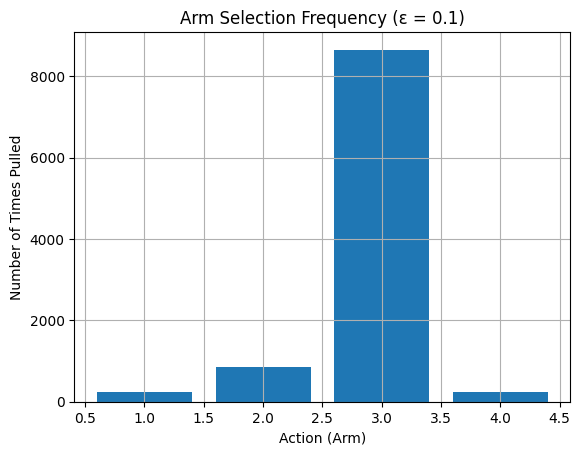

In [12]:
### GRADED CELL
eps = 0.1
k = 4
q = np.zeros(k)  # estimated rewards
n = np.zeros(k)  # count of pulls per arm

#Run ε-greedy algorithm for 10,000 rounds
# YOUR CODE HERE
#raise NotImplementedError()

for pull in range(10**4):
    # explore vs exploit
    if np.random.uniform(0, 1) < eps:
        idx = np.random.randint(0, k)
    else:
        idx = np.argmax(q)

    n[idx] += 1
    r = slots[idx, pull]                 # reward from chosen arm at this round
    q[idx] += (r - q[idx]) / n[idx]      # incremental mean update



#Display how many times each arm was pulled
print("Arm selection counts:", n)

#Visualise selection frequency
plt.bar(range(1, 5), n)
plt.xlabel("Action (Arm)")
plt.ylabel("Number of Times Pulled")
plt.title("Arm Selection Frequency (ε = 0.1)")
plt.grid(True)
plt.show()


### Compute the total reward amount over all the $10^4$ rounds

In [13]:
total_reward = 0
eps = 0.1
k = 4
q = np.zeros(k)
n = np.zeros(k)

for pull in range(10 ** 4):
    if np.random.uniform(0, 1) < eps:
        idx = np.random.randint(0, k)
    else:
        idx = np.argmax(q)
    n[idx] += 1
    r = slots[idx, pull]
    q[idx] += (r - q[idx]) / n[idx]
    total_reward += r

print("Total reward over 10,000 rounds:", total_reward)


Total reward over 10,000 rounds: 122168


### Try starting with different initial slot values

In [14]:
#Initialise q with small random values instead of zeros
eps = 0.1
k = 4
q = np.random.uniform(0, 1, k)
n = np.zeros(k)
total_reward = 0

for pull in range(10 ** 4):
    if np.random.uniform(0, 1) < eps:
        idx = np.random.randint(0, k)
    else:
        idx = np.argmax(q)
    n[idx] += 1
    r = slots[idx, pull]
    q[idx] += (r - q[idx]) / n[idx]
    total_reward += r

print("Total reward with randomized initial q:", total_reward)


Total reward with randomized initial q: 123492


## Question 3: Compare total rewards for different ε values

Now that you've seen how initialisation affects learning, explore how the **exploration rate (ε)** influences total reward.

Try running the ε-greedy algorithm with different values of ε and compare the results. What do you observe?

In [15]:
### GRADED CELL
eps_values = [0, 0.05, 0.1, 0.15, 0.5]
def run_e_greedy(eps, slots):
    k = 4
    q = np.zeros(k)
    n = np.zeros(k)
    total_reward = 0
    for pull in range(10 ** 4):
        if np.random.uniform(0, 1) < eps:
            idx = np.random.randint(0, k)
        else:
            idx = np.argmax(q)
        n[idx] += 1
        r = slots[idx, pull]
        q[idx] += (r - q[idx]) / n[idx]
        total_reward += r
    return total_reward

# YOUR CODE HERE
#raise NotImplementedError()

for eps in eps_values:
    reward = run_e_greedy(eps, slots)

    print(f"ε = {eps:.2f} → Total reward: {reward}")



ε = 0.00 → Total reward: 80000
ε = 0.05 → Total reward: 122227
ε = 0.10 → Total reward: 122106
ε = 0.15 → Total reward: 119033
ε = 0.50 → Total reward: 115316


## Question 4: Visualise cumulative reward over time

Now, visualise how the total reward builds up over time using the ε-greedy algorithm with ε = 0.1.

This helps you understand:

- How quickly the algorithm starts favouring better arms
- Whether learning stabilises or continues to fluctuate

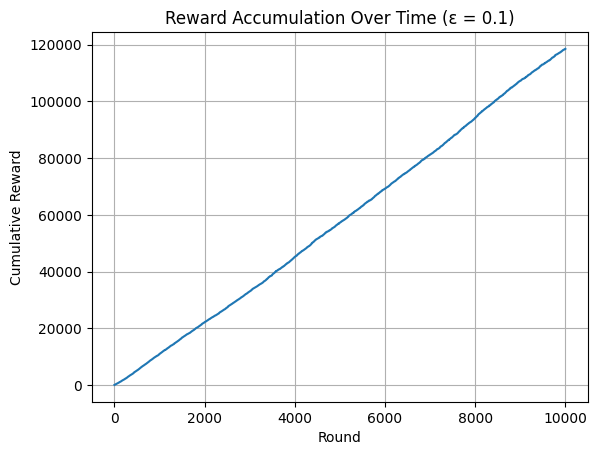

In [16]:
###GRADED CELL

eps = 0.1
k = 4
q = np.zeros(k)
n = np.zeros(k)
rewards = []
# Write the ε-greedy loop here
# YOUR CODE HERE
#raise NotImplementedError()

for pull in range(10**4):
    if np.random.uniform(0, 1) < eps:
        idx = np.random.randint(0, k)
    else:
        idx = np.argmax(q)

    n[idx] += 1
    r = slots[idx, pull]
    q[idx] += (r - q[idx]) / n[idx]
    rewards.append(r)

# Plot cumulative reward
plt.plot(np.cumsum(rewards))
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Reward Accumulation Over Time (ε = 0.1)")
plt.grid(True)
plt.show()


## Question 5: Implement ε-greedy with on-demand sampling

In earlier simulations, you pre-generated 10,000 samples for each slot machine. While useful for analysis, this approach is inefficient in real-world scenarios where you only observe one reward per pull.

In this question, you'll implement the ε-greedy algorithm using on-demand sampling, where each arm generates a reward only when pulled.

Each action below represents a slot machine with a unique reward distribution:

- **Action 1**: always returns 8

- **Action 2**: returns 0 (88%) or 100 (12%)

- **Action 3**: returns a random integer from −10 to 35

- **Action 4**: returns 0, 20 or a random integer from 8 to 18 (each with ⅓ probability)

Your task is to:

- Simulate 10,000 rounds using `ε = 0.1`.

- Track estimated rewards (`q`), pull counts (`n`) and total reward.

- Print the final total reward.

In [17]:
### GRADED CELL

def action_1(): return 8

def action_2():
    return 0 if np.random.uniform(0, 1) < 0.88 else 100

def action_3():
    return np.random.randint(-10, 36)

def action_4():
    u = np.random.uniform(0, 1)
    if u < 1/3:
        return 0
    elif u < 2/3:
        return 20
    return np.random.randint(8, 19)

actions = [action_1, action_2, action_3, action_4]

eps = 0.1
k = 4
q = np.zeros(k)
n = np.zeros(k)
total_reward = 0

# YOUR CODE HERE
#raise NotImplementedError()

rounds = 10_000

for t in range(rounds):
    # ε-greedy action selection
    if np.random.uniform(0, 1) < eps:
        idx = np.random.randint(0, k)      # explore
    else:
        idx = int(np.argmax(q))            # exploit

    # pull chosen arm (on-demand sampling)
    r = actions[idx]()

    # update counts and estimates
    n[idx] += 1
    q[idx] += (r - q[idx]) / n[idx]        # incremental mean

    # accumulate reward
    total_reward += r


print("Total reward with on-demand sampling:", total_reward)


Total reward with on-demand sampling: 123384


Congratulations! You successfully implemented and analysed the ε-greedy algorithm for solving the MAB problem. This gave you hands-on insight into balancing exploration and exploitation to maximise rewards.